In [1]:
%matplotlib widget

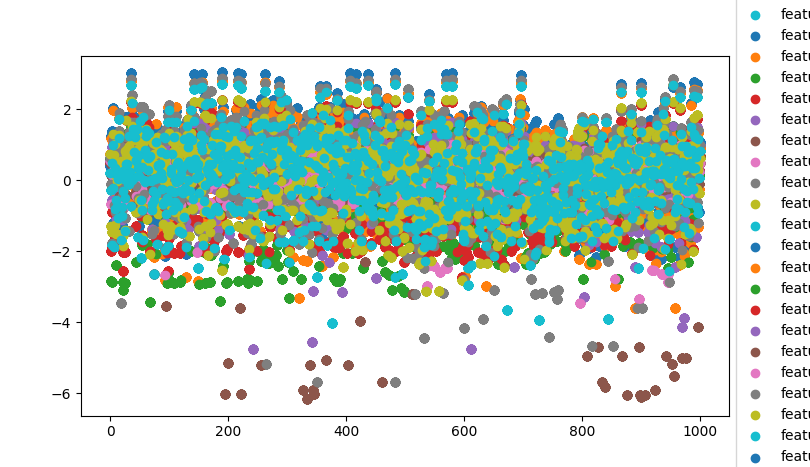

,id,id_job,feature_type_1_0_stand,feature_type_1_1_stand,feature_type_1_2_stand,feature_type_1_3_stand,feature_type_1_4_stand,feature_type_1_5_stand,feature_type_1_6_stand,feature_type_1_7_stand,feature_type_1_8_stand,feature_type_1_9_stand
0,0,-68888894506869945631,0.390617,0.727857,0.589099,0.488138,0.552816,0.476617,0.536111,0.636679,0.738897,0.210220
1,1,-45528547052692089371,1.244735,1.184115,-2.834308,-2.005010,0.748541,0.148144,-0.675595,-0.120870,-1.291557,-0.288599
2,2,33899130356965745151,1.382021,1.118533,-2.864514,-1.917006,0.937487,0.176908,-0.679913,0.603182,-1.462419,0.473127
3,3,-1697736982326412151,0.411210,0.495513,-0.200144,-0.889081,-0.552055,0.438574,0.156137,-1.763515,0.210943,-1.830828
4,4,-53991638443464865861,-1.199943,-1.351066,0.582128,0.535315,0.135947,0.476617,0.480518,-1.450446,0.511081,-0.234609
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,-55382527010294823101,-0.744937,-0.227754,0.229719,0.014549,0.248637,0.208457,0.225223,-0.602713,-0.255537,-0.754554
996,996,-38269269630739291871,0.630868,1.319961,0.496930,0.654166,0.753624,-4.125724,0.438419,1.414841,0.457744,1.170299
997,997,91717453934891372711,-0.860650,-1.313591,0.417928,-0.026278,0.113070,0.197322,0.367174,-1.197930,0.277841,-0.932955
998,998,-15903689633302548341,-0.900855,-0.241807,0.139099,0.288541,0.252026,-0.097747,0.216587,0.640544,-0.355885,0.059988


In [18]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import stddev, mean, col, udf, lit
from pyspark.sql.types import FloatType
from IPython.display import display
import matplotlib.pyplot as plot
import pandas as pandas


# Define function to compute Z-score
def z_score(x: int, mean: int, stddev: int) -> int: 
    return (x - mean) / stddev

# Convert function which compute Z-score into UDF
z_score_udf = udf(z_score, FloatType())

def normalize_data_z_score(train_df: DataFrame, test_df: DataFrame, cols_names: list[str], cols_new_name_function : callable = lambda col_new_name : col_new_name) -> DataFrame:
    """
    Transform data in CSV format by computing the Z-score standardization for each value in selected columns.
    
    Parameters:
        train_df (DataFrame): input DataFrame with train data.
        test_df (DataFrame): input DataFrame with tested data.
        columns_suffix (str): Column header's suffix which will be concat with original column name to create new column name for resulting values
    """

    # Iterate over feature_type_1_{i} columns and perform z-standardization for each value in a feature column
    for col_name in cols_names:
        mean_val = lit(train_df.select(mean(col_name)).collect()[0][0])
        stddev_val = lit(train_df.select(stddev(col_name)).collect()[0][0])

        new_col_name = cols_new_name_function(col_name)

        test_df = test_df.withColumn(col_name, z_score_udf(col(col_name), mean_val, stddev_val))\
                         .withColumnRenamed(col_name, new_col_name)

    return test_df


def plot_pandas_df(pandas_dataframe: pandas.DataFrame, y_axs: int, x_axs: int, title: str = "") -> plot:
    # Build the scatter plot
    plot.scatter(y_axs, x_axs)
    plot.xlabel(y_axs)
    plot.ylabel(x_axs)
    plot.title(title)
    return plot


def plot_pandas_df_mult(pandas_dataframe: pandas.DataFrame, x_axs: list, tittle : str = "") -> plot:
    # Build the scatter plot with multiple functions
    for col_name in pandas_dataframe:
        plot.scatter(x_axs, pandas_dataframe[col_name], label=col_name)
    
    plot.title(tittle)
    plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plot.subplots_adjust(left=0.1)
    return plot
        

if __name__ == "__main__":
    output_data_path = "../data/output/test_transformed.csv"

    spark = SparkSession.builder.appName("score-standardization-spark").getOrCreate()

    # Load *.csv
    train_df = spark.read.csv("../data/input/train.csv", header=True, inferSchema=True)
    test_df = spark.read.csv("../data/input/test.csv", header=True, inferSchema=True)

    # Enumerate column headers which starts with `feature_type_1`
    feature_cols = list(filter(lambda header: header.startswith("feature_type_1_"), test_df.columns))


    normalized_df = normalize_data_z_score(test_df, train_df, feature_cols, cols_new_name_function=lambda col_name : col_name + "_stand")
    
    pandas_df = normalized_df.toPandas()
    
    # Write transformed data to output CSV file with pandas to avoid fragmentation
    pandas_df.to_csv(output_data_path)
    
    # Select sub dataframe by certain columns to plot
    pandas_df_features = pandas_df.filter(regex=r'^feature_type_1_')

    plot = plot_pandas_df_mult(pandas_df_features, pandas_df["id"].tolist())
    
    plot.show()
    display(pandas_df)
    
    spark.stop()
